# MODELS NOTEBOOK
This notebook contains an experimentation with different models (KNN, Decision Tree, Random Forest and Logistic Regression. 
In [this notebook](https://github.com/sarrab/DMML2020_COOP/blob/main/code/LR_Models.ipynb) you will find The Logistic Regression experimentation. And in [this one](https://github.com/sarrab/DMML2020_COOP/blob/main/code/EDA.ipynb) you find the EDA notebook that permit us to explore data.
And finally in this one, you find the final version with more sophisticated cleaning.

# Importing Libraries
Importing the relevant packages: pandas, matplotlib, seaborn...

In [ ]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
sns.set_style("white")

import string


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from gensim.models.doc2vec import TaggedDocument

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier


import time

In [ ]:
# Import required packages
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# load English language model of spacy
sp = spacy.load('en_core_web_sm')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Import and download packages
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/project/training_data.csv")
df_test=pd.read_csv("https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/project/test_data.csv")


# Cleaning and Processing Functions and Data Sets To Run the models

Data sets and related functions are kept here to run the models

In [ ]:
# A function to do some text cleaning

def func_textcleaning(sentence):
    # remove unicode literals
    temp = sentence.encode('ascii',errors='ignore').decode('ascii')
    
    # remove &amp
    temp = temp.replace('&amp;', '')
    
    # remove urls
    temp = re.sub(r"http\S+", "", temp)
    
    # remove html
    temp = re.sub(r'<.*?>', "", temp)
    
    # remove hashtags
    temp = re.sub(r'#', "", temp)

    # remove people account with @
    temp = re.sub(r'@\S+', "", temp)
    
    return temp

In [ ]:
#A data celaning and tokenizer function with stemming.
  
def data_cleaner(sms):

    # Define stopwords
    stop_words = stopwords.words('english')

    # Define tokenizer and stemmer
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer
    
    # Remove digits
    sms = re.sub(r"\d+","", sms)
    
    # Lowercase
    sms = sms.lower()
    
    # Remove punctuation
    sms = re.sub(r"[^\w\s\d]","", sms)
    
    # Remove stop words
    sms = sms.split()
    sms = " ".join([word for word in sms if not word in stop_words])
    
    # Tokenize
    sms = word_tokenize(sms)
    
    # Stemming
    ps = PorterStemmer()
    sms = [ps.stem(word) for word in sms]
    
    return sms



In [ ]:
# A data celaning and tokenizer function without stemming. 
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove all word with less that 3 letters (remove noise)
    mytokens = [ word for word in mytokens if len(word)>2 ]

    # Return preprocessed list of tokens
    return mytokens

In [ ]:
df_train['text']=df_train.text.apply(lambda x:func_textcleaning(x))
df_test['text']=df_test.text.apply(lambda x:func_textcleaning(x))

In [ ]:
# Select features
X = df_train['text'] # the features we want to analyze
y = df_train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
X_train

6214    Take this China get demolished and sent back t...
5845    Explosion in Gaza Strip kills four wounds 30; ...
4250    Rolling sandunes the gentle lapping of the sea...
6154     GodsLove  thankU brother Danny for RT of NEW ...
6110    Wreckage 'Conclusively Confirmed' as From MH37...
                              ...                        
664      talk to please don't harm your self in any wa...
3276    'I did another one I did another one. You stil...
1318    Watch This Airport Get Swallowed Up By A Sands...
723     Cuban leader extends sympathy to Vietnam over ...
2863        it was hella crazy 3 fights an ambulance a...
Name: text, Length: 5176, dtype: object

In [ ]:
example_df=df_train[0:3].text
example_df

0    Black Eye 9: A space battle occurred at Star O...
1    world FedEx no longer to transport bioterror g...
2    Reality Training: Train falls off elevated tra...
Name: text, dtype: object

In [ ]:
# Cleanin with spacy tokenizer, without stemming 
example_df.apply(spacy_tokenizer)

0    [black, eye, space, battle, occur, star, o784,...
1    [world, fedex, longer, transport, bioterror, g...
2    [reality, training, train, fall, elevated, tra...
Name: text, dtype: object

# MODELS


Looking at different features and their relation with respect to each other, we  observed that out of many diffrent Our initial assumption is that the bydault predictors (keyword, location and especially text) have a correlation or perhaps a causality with the fact that a tweet is either real or not

We have run and fitted  different classifier to observe the behaviour under different model. We defined and fitted following models:   Logistic Regeression, Decision Tree Classifier, RandomForestClassifier, and  kNN classifiers. We applied the Grid Search to identify the optimal parameters for the kNNKlasifier. 

# Logistic Regression

---
Logistics Regression is one of the videly used tool to classify the labes. It is based on the probabilities, calculated by the logistic function. 

 Logistic regression classifier seems to outperform as far as the accuracy is concerned. One has to bear in mind the fact that in our case we have only two cases, true and false disaster alert.

We have  tried both data cleaning and preprocessing functions to compare the results. Cleaning data too much did not help increase the accuracy, this was another conclusion from the running this model.






In [ ]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

#with tthe first tokenizer,spacy_tokenizer, LogRegCV, the train accuracy is 0.923659403492505
#Submitted test accuracy is 0,8170

#With this model, data_cleaner (the model used in the dimention reduction example) was used
#Train accuracy was recorded as 0,9218. The test submission rate was 0,8074.

CPU times: user 1min 5s, sys: 22.6 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
#Train Accuracy  
%%time
pipe.score(X_train, y_train)

CPU times: user 51.7 s, sys: 10.8 ms, total: 51.7 s
Wall time: 51.9 s


0.9289026275115919

In [ ]:
# Predictions and evaluation for the model
%%time
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7876
CPU times: user 13.3 s, sys: 2.96 ms, total: 13.3 s
Wall time: 13.4 s


# Decision Tree Models
Decision tree models could be used for classification purposes. As decision tree gives a good visualisations, some times it is usefull to fit tree classifiers as well. 

We had fit DecisionTreeClassifier for various maximum depth parameters, in the range of 3-20. The trainin accuracy was increasing for higher max_depth parameters. This couls imply an underfitting. One can note this for further exploration regarding an optimal parameter for training accuracy. However,  we had observed that, the training accuracy for tree classifiers was relatively lower over all compared to the LogisticRegression.

In this section we make use of the graphviz library which helps show the decision criteria as well. Also, we make a search to observe the training and testin accuracies for different depths. It is visible from the plot that training accuracy is increasing for various depths from 50 to 150, while the testing accuracy do no change to much.

In [ ]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier: TREE CLASSIFIER
classifier = tree.DecisionTreeClassifier(max_depth=10)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

#Train Accuracy
print("Train accuracy:",pipe.score(X_train, y_train))
#Test Accuracy

#Train Accuracy with DecisionTree classifier with max_depth was9, 0,6834
#the test of submitted was0,6524

Train accuracy: 0.6989953632148377
CPU times: user 1min 41s, sys: 19.4 ms, total: 1min 41s
Wall time: 1min 41s


In [ ]:

# Predictions and evaluation for the model
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))


0.6541


In [ ]:
featuresNames = tfidf.get_feature_names()
featuresNames
type(featuresNames)

list

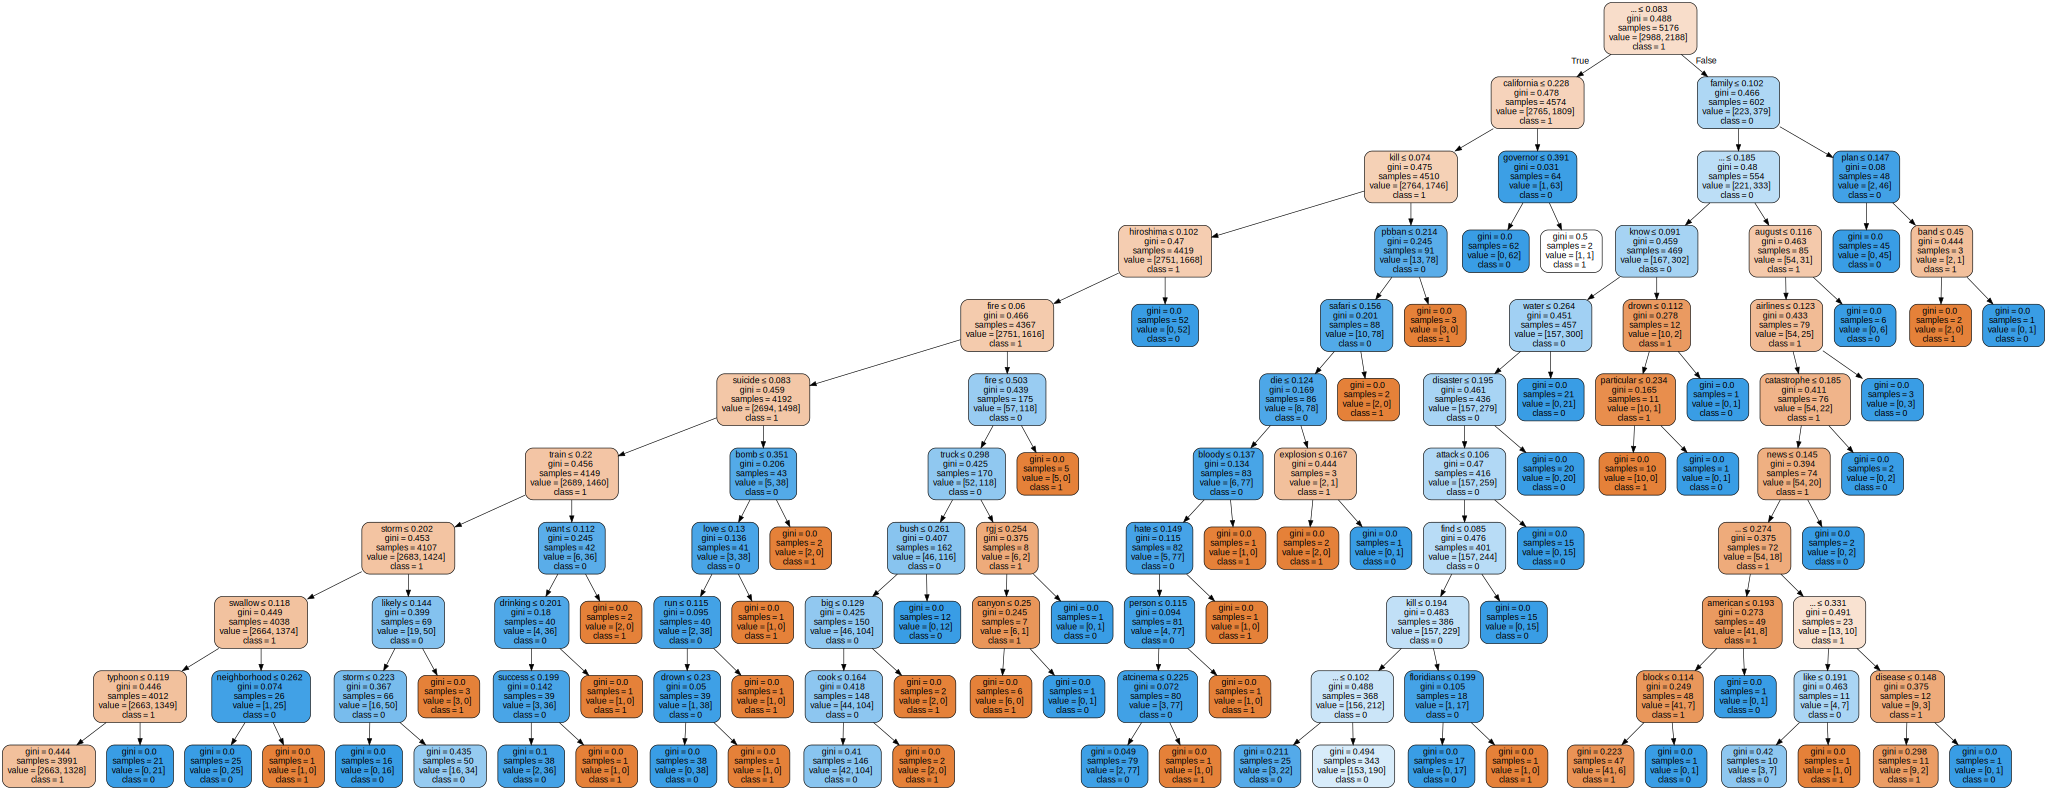

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(classifier, out_file=None,
                               feature_names=featuresNames,
                               class_names=['1','0'],filled=True,
                                rounded=True,  
                              special_characters=True) 
graph = graphviz.Source(dot_data)
graph.render("Gini")
graph

Below is a  a code to identify the search for optimal depth for the tree classifier. In order to save from time, we implemented for depth from 50 to 150. As it takes long time to process for this depth and this number of trees, the data was saved locally and later used for the plotting. 

In [ ]:
# Define vectorizer
accuracy_train=[]
accuracy_test=[]
for depth in range(0,1):#We had run it or the range of (50,150). To avoid keeping it bussy we left like this. 
  tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier: TREE   
  classifier = tree.DecisionTreeClassifier(max_depth=depth)
 
# Create pipeline
  pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
  pipe.fit(X_train, y_train)

#Train Accuracy
#    print("Train accuracy:",pipe.score(X_train, y_train))
#Test Accuracy

#Train Accuracy with DecisionTree classifier with max_depth was,
#the test of submitted was
  y_pred = pipe.predict(X_test)

# Evaluate model
  accuracy_train.append(round( pipe.score(X_train, y_train),4))
  accuracy_test.append(round(accuracy_score(y_test, y_pred), 4))
    #accuracy[(token,depth)]=(pipe.score(X_train, y_train),round(accuracy_score(y_test, y_pred), 4))
#Plot of accuracies wrt to tokenizer and maximum depth choices 

In [ ]:
#Putting train and test accuracies into a data frame 
accuracies=pd.DataFrame()
accuracies['Train Accuracies']=accuracy_train
accuracies['Test Accuracies']=accuracy_test



In [ ]:
#Saving values to the local drive
from google.colab import files
accuracies.to_csv('accuracies.csv', index=False) 
files.download('accuracies.csv')

In [ ]:
# Reading the csv  file from the github directory
df2=pd.read_csv('https://raw.githubusercontent.com/sarrab/DMML2020_COOP/main/documents/accuracies.csv')

Text(0.5, 0, 'tree depths')

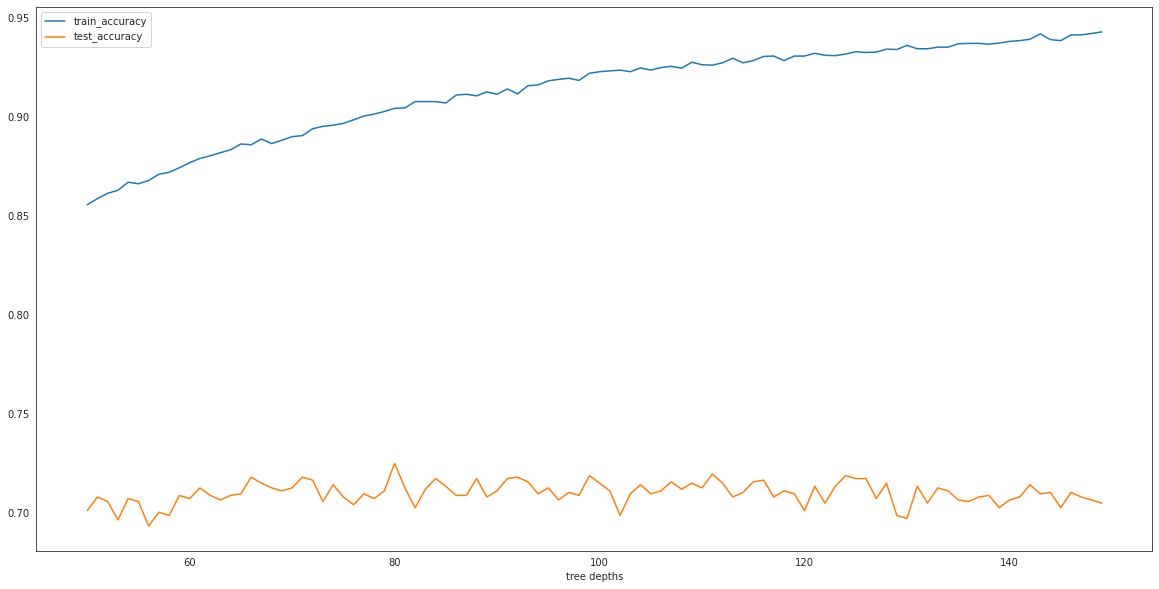

In [ ]:
#Plotting train and test accuraciy with respect to tree depths.
accuracy_train=df2['Train Accuracies']
accuracy_test=df2['Test Accuracies']

plt.figure(figsize=(20,10))
plt.plot(range(50,150), accuracy_train, label="train_accuracy")
plt.plot(range(50,150), accuracy_test, label="test_accuracy")
plt.legend(fontsize=10)

#label naming
plt.xlabel("tree depths")


# KNN Model and Grid Search

The k-nearest neighbours algorithm(k-NN), is a classification algorithm based on the k nearest elements. With the k-NN algorithmes the risk of overfitting is high. 


The bias is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs. In other words, model with high bias pays very little attention to the training data and oversimplifies the model.

The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs. In other words, model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. (source:  [K-Nearest Neighbors and Bias](https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb))


A low k value would give less bias but a hiher variance. As it focusses more on the training data, it would miss the test data, the error would be higher. 

On the other hand, a higher k value would oversimplfy the model, It will decrease the variance but the model would be biased. Again the model error would be higher. 

 A grid search would be useful to identify the optimal hyperparameters for the k-nn algorithme.  When we run the grid search,  to increase the accuracy. 

In our case, the grid searche provided{'n_neighbors': 20, 'p': 2, 'weights': 'distance'} hyper parameters. We defined the model according to these parameters and fitted. Since initially the model had given different parameters out of some errors, we had not chance to submit the results based on these optimal parameters before the closure of the competition.




In [ ]:

start=time.time()
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = KNeighborsClassifier(n_neighbors=20)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

end=time.time()
print("time: ", end-start)

time:  48.85028338432312


In [ ]:
#Train Accuracy  of KNN
%%time
pipe.score(X_train, y_train)

# Predictions and evaluation for the model

y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7112
CPU times: user 1min 2s, sys: 248 ms, total: 1min 2s
Wall time: 1min 2s


In [ ]:
# Grid Search - hyperparameters tunning
from sklearn.model_selection import GridSearchCV
start=time.time()
# Define parameters to test
grid = {'n_neighbors':np.arange(10,22),#this was run for range (1,100).
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)


# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', knn_cv)])

pipe.fit(X_train, y_train)
end=time.time()
print("time: ", end-start)
# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))
#print("Test Score:", round(knn_cv.score(X_test, y_test), 4))

time:  127.64063835144043
Hyperparameters: {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
Train Score: 0.7425


0.7228


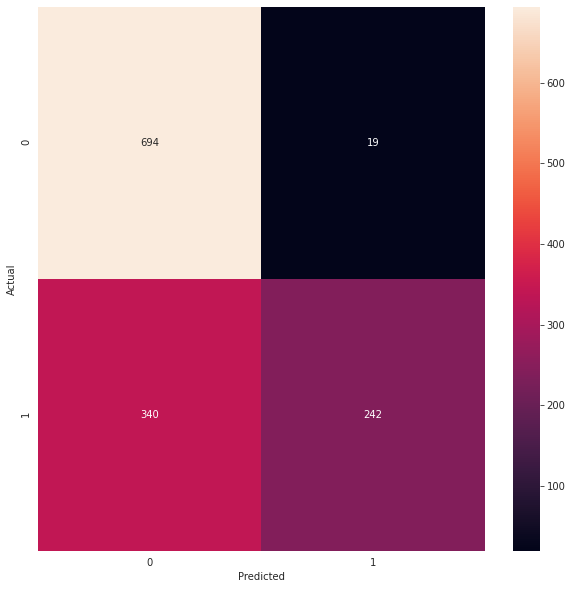

In [ ]:
# Fit optimal KNN model based on the parameters of above GridSearch
knn = KNeighborsClassifier(n_neighbors=20, p=2, weights='distance')


# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', knn)])

pipe.fit(X_train, y_train)

# Prediction for test set
y_pred = pipe.predict(X_test)

# Evaluate model
def accuracy_conf_mat(y_test, y_pred):
  print(round(accuracy_score(y_test, y_pred), 4))
  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

accuracy_conf_mat(y_test, y_pred)
#train accuracy:0,985 Test Accuracy: 0,76

### Random Forest 

Random Forest is also a supervised learning algorithm. Random Forest Classifier would select among the decision tree classfiers the optimal one. Randoom Forest makes use of randomly selected features to evaluate the best features combination.

Random Forest Classifier has its own advantages and disadvantages.first of all, a random forest have advantages to overcome the problem of overfitting. On the other hand, as many trees are tested, it takes long time. 

As Random Forest algorithm work on the different set of the features,  this can be utilized for feature selection. Based on the classifier performance, the optimal set of features would be chosen.


In [ ]:

# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define and fit model
classifier=RandomForestClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

#model fitting
start=time.time()
pipe.fit(X_train, y_train)
end=time.time()
print("time: ", end-start)


#Train Accuracy  
print("train score:", round(pipe.score(X_train, y_train), 4))

#Test Accuracy
y_pred = pipe.predict(X_test)
print("test score:", round(pipe.score(X_test, y_test), 4))
#Rsult for TEST DATA: training:0,985,  TEst: 0,800

time:  55.7916579246521
train score: 0.9867
test score: 0.7668


One of the useful property of the RandomForestClassifer is the "*feature_importances_*". One can identify the most important features. To find important features with Random Forest Classifier, one has to fit the model and get the feature scores, which is based on the features' relative importances. 

These are shown in the following steps. As it will be clear from the result, given that there are around 10'000 features in the matrix, however, some of these features has negligible importances. One can base the estimation on the features having higher relative importance. 


In [ ]:
# creating random forest classifier with n_estimators = 150
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=data_cleaner)
classifier=RandomForestClassifier(n_estimators=150, random_state=0)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

#model fitting
start=time.time()
pipe.fit(X_train, y_train)
end=time.time()
print("time: ", end-start)


#Train Accuracy  
print("train score:", round(pipe.score(X_train, y_train), 4))

#Test Accuracy
y_pred = pipe.predict(X_test)
print("test score:", round(pipe.score(X_test, y_test), 4))


time:  12.780359029769897
train score: 0.9865
test score: 0.7768


In [ ]:
X_train_vec=tfidf.fit_transform(X_train)

In [ ]:
cols=tfidf.get_feature_names()


In [ ]:
X_train_new=pd.DataFrame(X_train_vec.todense(),columns=cols)


In [ ]:
# view the feature scores

feature_scores = pd.Series(classifier.feature_importances_, index=cols).sort_values(ascending=False)

feature_scores[0:5000]

fire         0.012013
hiroshima    0.009137
kill         0.007941
wildfir      0.007121
flood        0.006743
               ...   
boyd         0.000014
talkin       0.000014
met          0.000014
billiton     0.000014
treati       0.000014
Length: 5000, dtype: float64

# Resampling for  balanced labels 
In order to use a balanced data set, that is to say a data set where the labes have eqaul distributions. This can be achieved by selecting a smaller sample where labels  have equal portions. 

When we fit the models with this new data set, we have observed that the accuracies decreased. We interpret this the result of data-loss. 

In [ ]:
# Create balanced dataframe - base rate = 0.5 
df_new = pd.concat([df_train[df_train["target"] == 0].sample(len(df_train[df_train["target"] == 1])), df_train[df_train["target"] == 1]], axis=0).reset_index()
df_new


index     id  ...                                               text target
0      5947    753  ...  2 TIX 10/3 Frozen Fury XVII: Los Angeles Kings...      0
1      4959   8741  ...  Do you feel like you are sinking in unhappines...      0
2      2855    941  ...               alrighty Hit me up and we'll blaze!!      0
3      5117   1343  ...  Man why hasn't  blown up? He's still underground.      0
4      2463   6594  ...  Hi  sorry for the delay. Slightly inundated wi...      0
...     ...    ...  ...                                                ...    ...
5535   6465   8330  ...  China's Stock Market Crash: Are There Gems In ...      1
5536   6466   4377  ...  Earthquake Sismo M 1.9 - 15km E of Anchorage A...      1
5537   6468   9794  ...  Hollywood Movie About Trapped Miners Released ...      1
5538   6469  10344  ...  Friendly reminder that the only country to eve...      1
5539   6470   1779  ...  Buildings are on fire and they have time for a...      1

[5540 rows x 6 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


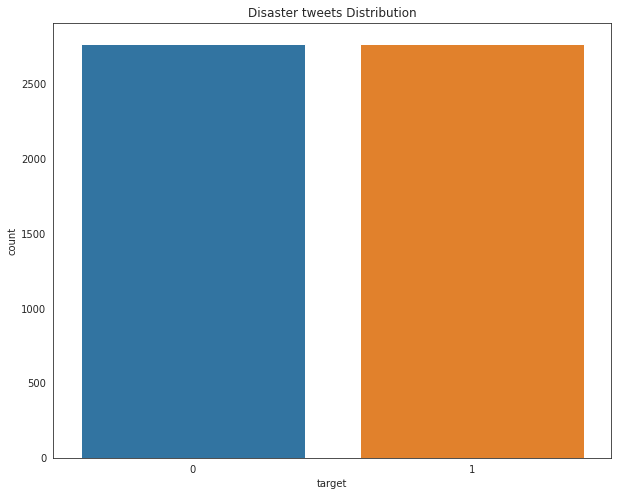

In [ ]:
##checking frequency of each
plt.subplots(1,1,figsize=(10,8))
sns.countplot('target',data=df_new) 
plt.title("Disaster tweets Distribution")
plt.show()

In [ ]:
#Data Cleaning 
df_new['text']=df_new.text.apply(lambda x:func_textcleaning(x))

In [ ]:
#Tf-idf with logistic regression
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: user 1min, sys: 24.8 ms, total: 1min
Wall time: 1min


In [ ]:
#Train Accuracy  
%%time
pipe.score(X_train, y_train)

CPU times: user 49.7 s, sys: 3.89 ms, total: 49.7 s
Wall time: 49.7 s


0.9289026275115919

In [ ]:
# Predictions and evaluation for the model
%%time
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7876
CPU times: user 12.9 s, sys: 2.99 ms, total: 12.9 s
Wall time: 12.9 s


In [ ]:
#Submission performance result
#while internal train and test accuracies were 0,94 and 0,79 respectively,
 #the submission result is:the train accuracy was 0,93 and the test accuracy was informed as 0.8117 

# Dimentionality Reduction
Dimensionality reduction is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data. In a higher dimentional space, it is often very hard and difficult to iterpret and conduct computations as well.

Principal component Analysis (PCA) is a technique that is used to automatically apply dimentionality reduction. The moddule PCA,  project data points in the lower dimensional space in the direction that retains maximum variance.

In [ ]:
# Define vectorizer - use above cleaning function
tfidf = TfidfVectorizer(sublinear_tf=True, tokenizer=spacy_tokenizer, ngram_range=(1,1), min_df=3, max_df=0.9)

# Fit and transform X_train and X_test
X_train_vec = tfidf.fit_transform(X_train).toarray()
X_test_vec = tfidf.transform(X_test).toarray()
print(X_train_vec.shape)
X_train_vec

(5176, 2586)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#PCA 
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=2)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

Shape after PCA:  (5176, 2)
Number of components:  2
Explained variance ratio:  0.011022979760183288


In [ ]:
# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('logistic reg', LogisticRegression()),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
#print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  1.153
Train Accuracy:  0.6401


In [ ]:
# With PCA and but not standardization

# Define Model
pipe = Pipeline([
                 
                 ('pca', pca),
                 ('logistic reg', LogisticRegression(max_iter=3000)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  1.2128
Train Accuracy:  0.6403
Test Accuracy:  0.6232


In [ ]:
#Data for submission
X_train_vec = tfidf.fit_transform(df_train.text).toarray()
X_test_vec = tfidf.transform(df_test.text).toarray()

print(X_train_vec.shape)


# Define PCA
pca = PCA(n_components=2)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

(6471, 2991)
Shape after PCA:  (6471, 2)
Number of components:  2
Explained variance ratio:  0.010290918448489901


In [ ]:
y_train=df_train.target

In [ ]:
#fit with the train data: features and labels.
start=time.time()
pipe.fit(X_train_vec, y_train)
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
end=time.time()
print("time: ", end-start)

Train Accuracy:  0.6402
time:  1.8386788368225098


# LESSONS LEARNED and CONCLUSION

Text analysing is one of the field which has been on exploration with the advent of the machine learning tools and the capabilities. Also, given the nature of the texts, words and speeches, text analytics is rather complicated to grasp. The most videly used techniques includes vectorizing the words into number matrices. This way one can implement  machine learning algorithms and make prediction.

 We have seen that usually these data matrices are made up of over several thousands features. This brings first of all a capacity and time constraint for computation. One has to well optimize and design the problem before  hand. For example, an algorithme to evaluate different tree depths had costed us more than 10h. We were blocked not to move anywhere to  keep the machine open and running.  

While doing this projects, we had realized that, different classifier models can have different results and efficiencies. However, the most important  aspect is the data handling stage where the data is cleaned, processed and vectorized. This requires a deep understanding of the underlying steps.

In a nutshell, text analytics require vide range of linguistic techniques apart from the numeric calculations involved.